In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.__version__

Found GPU at: /device:GPU:0


'2.2.0'

In [2]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
#%load_ext tensorboard

In [ ]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [3]:
tf.random.set_seed(999)
np.random.seed(999)

#### Datasets managing

In [ ]:
# default dataset
#!wget 'cdn.daitan.com/dataset.zip'
# dataset_file_name = './dataset.zip'
# with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
#     zip_ref.extractall('./dataset')

In [4]:
#path_to_dataset = "./dataset/tfrecords" #default
path_to_dataset = "./records"

In [5]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))
test_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'test_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)
print("Test file names: ", test_tfrecords_filenames)

Training file names:  ['./records/train_0.tfrecords']
Validation file names:  ['./records/val_0.tfrecords']
Test file names:  ['./records/test_0.tfrecords', './records/test_1.tfrecords']


In [6]:
### configuration
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [39]:
#####################################################################################
### I struggled with an error when opening .mp3 files                             ###
### Spent almost a working day trying to fix it                                   ###
### In the end I gave up and converted the whole dataset to .wav with ffmpeg CLI  ###
### This line may take a while, uncomment and launch with discretion. Recommend to have less files in folder
#!for i in ./cv-corpus-6.1-2020-12-11/ru/clips/*; do ffmpeg -i $i ./cv-corpus-6.1-2020-12-11/ru/clips/${i/%mp3/wav}; done

### Prepare Input features & Create tf.Data.Dataset

In [32]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase

In [65]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [66]:
test_dataset = tf.data.TFRecordDataset([test_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

In [67]:
val_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
val_dataset = val_dataset.map(tf_record_parser)
val_dataset = val_dataset.repeat(1)
val_dataset = val_dataset.batch(512)

### Model

In [73]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [74]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [75]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [76]:
def sdr_loss(y_true, y_pred):
    yt_norm = tf.reduce_sum( tf.square(y_true) )
    dif_norm = tf.reduce_sum( tf.square(y_true - y_pred) )
    
    return tf.math.log(dif_norm / yt_norm + 1e-3) + 1

In [83]:
### in the end of that block is loss choice

def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', #####<================================ LOSS =================###
  #model.compile(optimizer=optimizer, loss=sdr_loss,
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [84]:
model = build_model(l2_strength=1e-4)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 137, 8, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 129, 1, 18)   1296        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 129, 1, 18)   0           conv2d_80[0][0]                  
____________________________________________________________________________________________

In [48]:
#model = tf.keras.models.load_model('./denoiser_cnn_log_mel_generator.h5')

In [ ]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [90]:
#%tensorboard --logdir logs

### Model training

In [85]:
baseline_val_loss = model.evaluate(val_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

785/785 [==============================] - 37s 47ms/step - loss: 0.0686 - rmse: 1.1653
Baseline accuracy 0.068608358502388


In [86]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

In [20]:
# dataset fixed, mse loss
model.fit(train_dataset,
         steps_per_epoch=200, # you might need to change this
         validation_data=test_dataset,
         epochs=5,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/5
200/200 [==============================] - 25s 123ms/step - loss: 0.8092 - rmse: 0.8872 - val_loss: 0.7858 - val_rmse: 0.8739
Epoch 2/5
200/200 [==============================] - 24s 118ms/step - loss: 0.4856 - rmse: 0.6809 - val_loss: 0.6480 - val_rmse: 0.7913
Epoch 3/5
200/200 [==============================] - 25s 123ms/step - loss: 0.4231 - rmse: 0.6336 - val_loss: 0.6072 - val_rmse: 0.7652
Epoch 4/5
200/200 [==============================] - 24s 118ms/step - loss: 0.4211 - rmse: 0.6321 - val_loss: 0.5842 - val_rmse: 0.7502
Epoch 5/5
200/200 [==============================] - 24s 120ms/step - loss: 0.4132 - rmse: 0.6260 - val_loss: 0.5671 - val_rmse: 0.7389


In [21]:
### additional 10 epochs => 15 overall
model.fit(train_dataset,
         steps_per_epoch=200, # you might need to change this
         validation_data=test_dataset,
         epochs=10,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/10
200/200 [==============================] - 24s 120ms/step - loss: 0.4012 - rmse: 0.6166 - val_loss: 0.5654 - val_rmse: 0.7379
Epoch 2/10
200/200 [==============================] - 24s 122ms/step - loss: 0.3837 - rmse: 0.6024 - val_loss: 0.6024 - val_rmse: 0.7627
Epoch 3/10
200/200 [==============================] - 24s 120ms/step - loss: 0.3697 - rmse: 0.5909 - val_loss: 0.5396 - val_rmse: 0.7205
Epoch 4/10
200/200 [==============================] - 25s 127ms/step - loss: 0.3746 - rmse: 0.5952 - val_loss: 0.5360 - val_rmse: 0.7182
Epoch 5/10
200/200 [==============================] - 25s 126ms/step - loss: 0.3858 - rmse: 0.6048 - val_loss: 0.5363 - val_rmse: 0.7186
Epoch 6/10
200/200 [==============================] - 24s 120ms/step - loss: 0.3922 - rmse: 0.6102 - val_loss: 0.5556 - val_rmse: 0.7320
Epoch 7/10
200/200 [==============================] - 22s 111ms/step - loss: 0.3831 - rmse: 0.6029 - val_loss: 0.5192 - val_rmse: 0.7068
Epoch 8/10
200/200 [=====================

In [ ]:
val_loss = model.evaluate(val_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

In [48]:
#model = tf.keras.models.load_model('./denoiser_cnn_log_mel_generator.h5')

### Testing

In [23]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr

from data_processing.feature_extractor import FeatureExtractor

# def play(audio, sample_rate):
#     ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [24]:
def prepare_input_features(stft_features):

    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    print(noisySTFT.shape)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [25]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

In [28]:
def inverse_stft_transform(stft_features, window_length, overlap):
    return librosa.istft(stft_features, win_length=window_length, hop_length=overlap)

def revert_features_to_audio(features, phase, window_length=windowLength, overlap=overlap, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return inverse_stft_transform(features, window_length=window_length, overlap=overlap)

#### ------------ Obtaining audio from dataset------------------

In [29]:
def audio_from_set(dataset, n =0, clean = False):
    iter = 0
    for rec in dataset:
        if iter == n:
            #return revert_features_to_audio(rec[0], np.transpose(rec[2]))
            return rec[clean], np.transpose(rec[2])
        iter += 1
    return None

##### VALIDATION set ######

In [55]:
idx = 50 #number of file

### CLEAN
clean_audio_val = revert_features_to_audio(*audio_from_set(val_dataset, idx, clean=True))
ipd.Audio(data=clean_audio_val, rate=fs)

In [56]:
mags1, nois1 = audio_from_set(val_dataset, idx)
print("Min:", np.min(mags1),"Max:",np.max(mags1))
print("Min:", np.min(nois1),"Max:",np.max(nois1))

Min: -0.83727705 Max: 11.267437
Min: -3.1415927 Max: 3.1415927


In [57]:
### NOISY
noisy_val = revert_features_to_audio(mags1.numpy()[:,:, 7,:], nois1)
print("Min:", np.min(noisy_val),"Max:",np.max(noisy_val))
ipd.Audio(data=noisy_val, rate=fs)

Min: -0.29370323 Max: 0.2625052


In [58]:
#### DENOISED
feats1 = model.predict(mags1)
denoised_val = revert_features_to_audio(feats1, nois1)
print("Min:", np.min(denoised_val),"Max:",np.max(denoised_val))
ipd.Audio(data=denoised_val, rate=fs)

Min: -0.41535532 Max: 0.44333485


Text(0.5, 1.0, 'Denoised Audio')

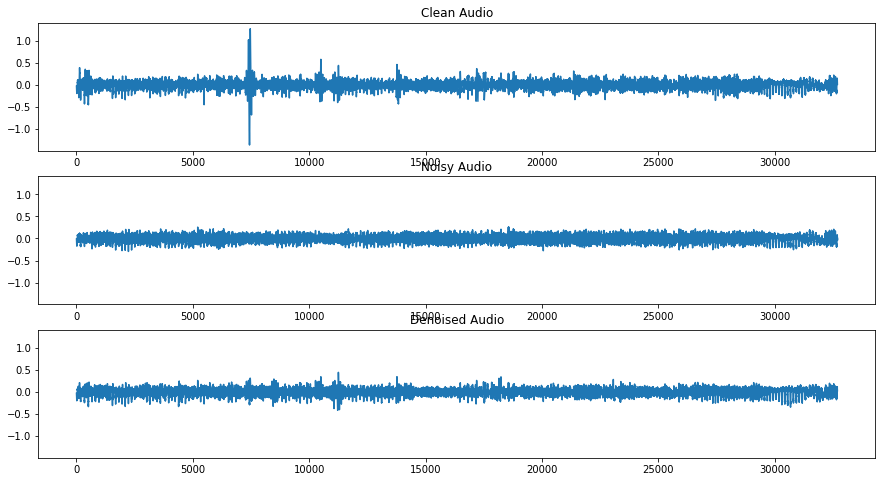

In [59]:
### SDR LOSS result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))
#plt.plot(figsize=(15,8))

ax1.plot(clean_audio_val)
ax1.set_title("Clean Audio")

ax2.plot(noisy_val)
ax2.set_title("Noisy Audio")

ax3.plot(denoised_val)
ax3.set_title("Denoised Audio")

Text(0.5, 1.0, 'Denoised Audio')

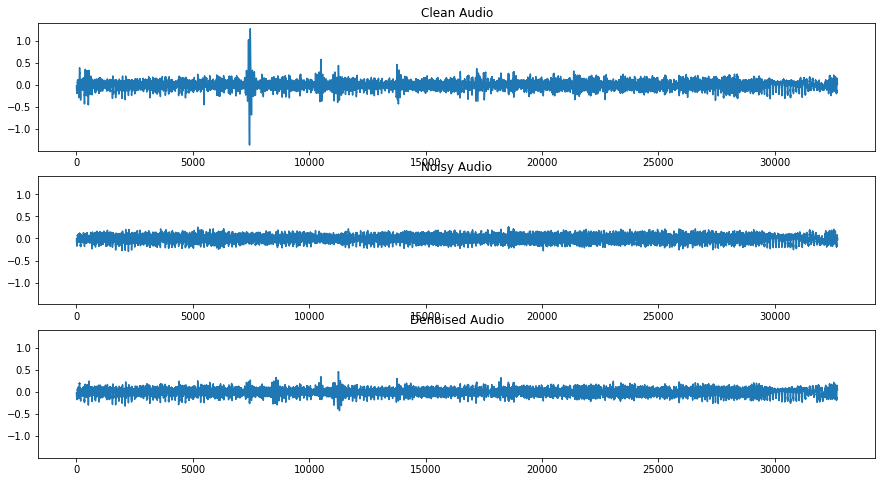

In [41]:
### MSE LOSS result

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))
#plt.plot(figsize=(15,8))

ax1.plot(clean_audio_val)
ax1.set_title("Clean Audio")

ax2.plot(noisy_val)
ax2.set_title("Noisy Audio")

ax3.plot(denoised_val)
ax3.set_title("Denoised Audio")

##### TEST SET #######

In [60]:
idx = 35

### CLEAN
clean_audio_test = revert_features_to_audio(*audio_from_set(test_dataset, idx, clean=True))
ipd.Audio(data=clean_audio_test, rate=fs)

In [61]:
mags3, nois3 = audio_from_set(test_dataset, idx)
print("Min:", np.min(mags3),"Max:",np.max(mags3))
print("Min:", np.min(nois3),"Max:",np.max(nois3))

Min: -0.7545949 Max: 11.301212
Min: -3.1415927 Max: 3.1415927


In [62]:
### NOISY
noisy_test = revert_features_to_audio(mags3.numpy()[:,:, 7,:], nois3)
print("Min:", np.min(noisy_test),"Max:",np.max(noisy_test))
ipd.Audio(data=noisy_test, rate=fs)

Min: -0.26537195 Max: 0.2632527


In [63]:
### DENOISED
feats3 = model.predict(mags3)
denoised_test = revert_features_to_audio(feats3, nois3)
print("Min:", np.min(denoised_test),"Max:",np.max(denoised_test))
ipd.Audio(data=denoised_test, rate=fs)

Min: -0.35683286 Max: 0.33230725


Text(0.5, 1.0, 'Denoised Audio')

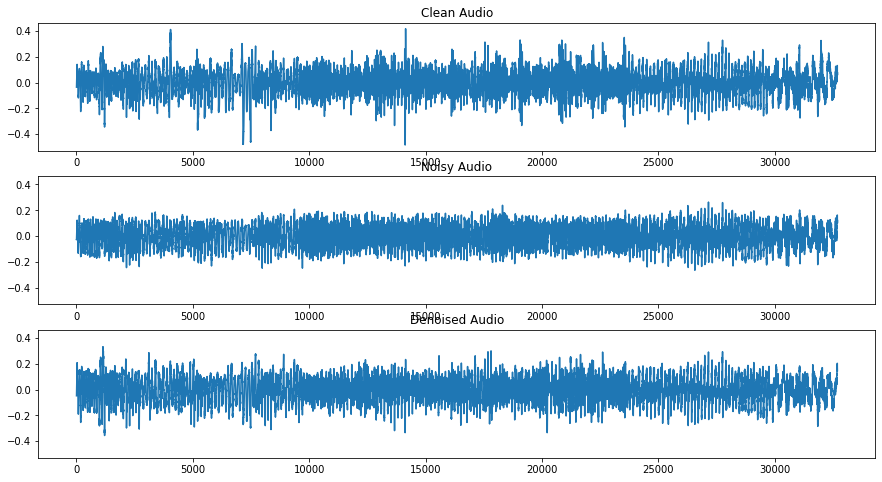

In [64]:
### SDR LOSS

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))
#plt.plot(figsize=(15,8))

ax1.plot(clean_audio_test)
ax1.set_title("Clean Audio")

ax2.plot(noisy_test)
ax2.set_title("Noisy Audio")

ax3.plot(denoised_test)
ax3.set_title("Denoised Audio")

Text(0.5, 1.0, 'Denoised Audio')

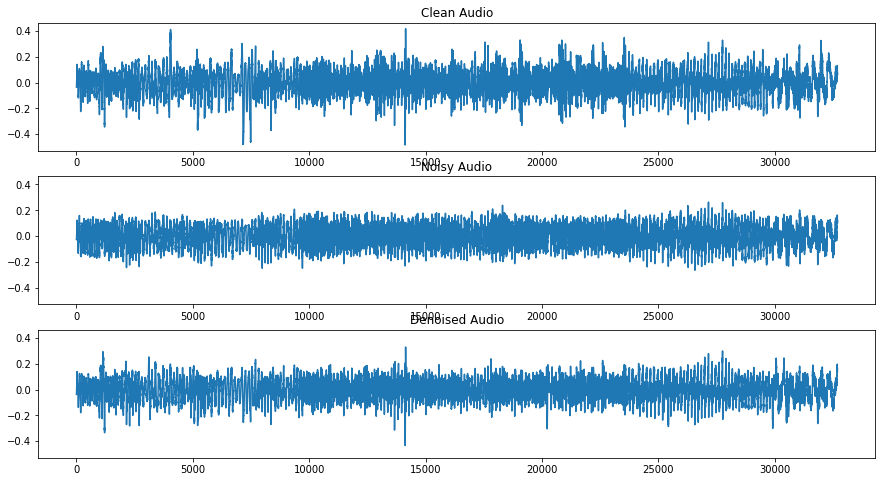

In [46]:
### MSE LOSS

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))
#plt.plot(figsize=(15,8))

ax1.plot(clean_audio_test)
ax1.set_title("Clean Audio")

ax2.plot(noisy_test)
ax2.set_title("Noisy Audio")

ax3.plot(denoised_test)
ax3.set_title("Denoised Audio")

In [ ]:
################################################################
### The behaviour of the model on a newly introduced dataset is weird
### rmse becomes uncorrelated with loss at some point
### some training attempt give a slight subjective enhancement of audio quality
### but still worse than the results obtained with original dataset with 100 epochs and 400 st./ep.
###
### The problem with the original dataset is impossibility to check the initial files for train dataset
### the data restored from tfrecords sounds like gibberish; roughly the same situation with new dataset
### val / test set sounds can be recovered rather fine
#################################################################

##### TRAIN ##### irrelevant

In [85]:
nth = 10
mags2, nois2 = audio_from_set(train_dataset, nth)
feats2 = model.predict(mags2)
feats2.shape

(512, 129, 1, 1)

In [86]:
### CLEAN
ipd.Audio(data=revert_features_to_audio(*audio_from_set(train_dataset, nth, clean=True)), rate=fs)

In [87]:
### NOISY
first_t = revert_features_to_audio(mags2.numpy()[:,:, 7,:], nois2)
print("Min:", np.min(first_t),"Max:",np.max(first_t))
print(first_t.shape)
ipd.Audio(data=first_t, rate=fs)

Min: -0.2328083 Max: 0.2179811
(32704,)


In [88]:
### DENOISED
denois2 = revert_features_to_audio(feats2, nois2)
print("Min:", np.min(denois2),"Max:",np.max(denois2))
print(denois2.shape)
ipd.Audio(data=denois2, rate=fs)

Min: -1.429794 Max: 1.2630367
(32704,)


In [89]:
first_t.shape

(32704,)